In [4]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [5]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical linear regression


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical regression

* Hierarchical  regression is  a generalization of linear regression, which allows learning a set of related linear regression models.

* Assume we have $k$ covariates and $m$ groups.

* The $i$-th model has its own parameters $\alpha_i, \beta_{1i}, \beta_{ki}$.

* Varying-intercept model: the intercepts of the different models ($ \alpha_1,.. \alpha_m$) are assumed to be samples from a population of intercepts.

* Varying-slope model makes the same assumption also for   $\beta$.

* This allows modelling observations which are divided in groups.

# Hierarchical (or multilevel) regression

*Hierarchical regression* is a sensible compromise between:

* *pooled regression*, i.e., fitting a single regression model by merging all observations, ignoring the groups; 


* *unpooled regression*, i.e., fitting an independent regression for each group.  This is unreliable on groups containing few observations and prevents making predictions for new  groups for which there are not yet observations (even if you have already done trials in different hospitals, it is not possible predicting the outcome of the trial in a new hospital).

# The radon problem

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon problem 



* Radon  is a radioactive gas; it is  the highest cause of lung cancer in non-smokers.



* Its level is  generally higher in the basement; moreover, its presence depends on the  type of soil.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota.


* For each measure we know:
    * the floor (basement or  first floor) 
    * the county (Minnesota is divided into 85 counties)

 
* The data set is published :  Gelman et al., "Data Analysis Using Regression and Multilevel/Hierarchical Models" 2007 (http://www.stat.columbia.edu/~gelman/arm/).

### Data import

In [6]:
# Import radon data, 919 rows
radon_data = pd.read_csv('data/radon.csv', index_col=0)

#response variable (log radon)
log_radon  = radon_data.log_radon.values

#the floor: 0 (ground level) or 1 (first floor).
floor  = radon_data.floor.values


#list of  counties in Minnesota (85 different counties)
counties_list = radon_data.county.unique()
n_counties = counties_list.shape[0] 

#this is the county index for each measure
county  = radon_data.county_code.values

#code and name of each county
county_lookup = dict(zip(counties_list, np.arange(n_counties)))




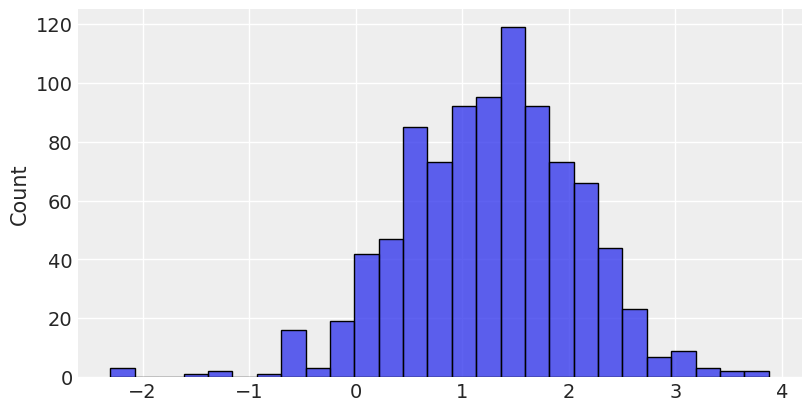

In [7]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

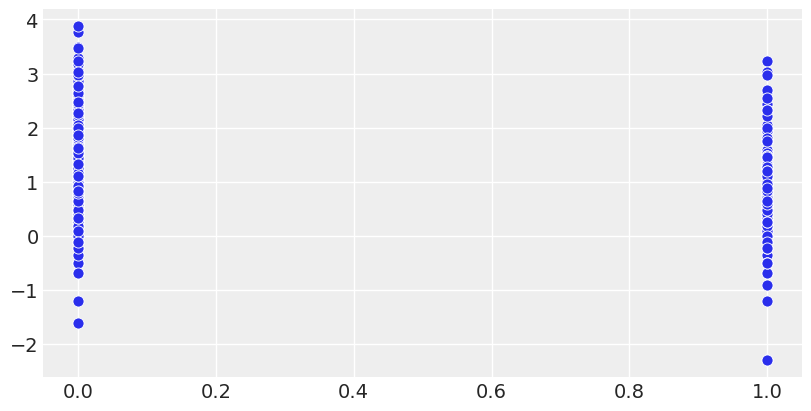

In [12]:
#floor takes only 0 and 1 as values
#The radon is higher in the basement (floor = 0)
#than in the first floor (floor = 1).
sns.scatterplot(x=floor, y=log_radon);

# Pooled regression

This model predicts log-radon using only the floor, merging data from all counties:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: log-radon

* $X$: floor (1 or 0)

* $\alpha$ : intercept.  (if we centered $X$ as recommended, it represents the baseline log-radon level in the whole Minnesota, averaging between floor 0 and 1). 


# Centering the covariate and setting the prior 

* As recommended we  center the covariate:  $X_c = X - \bar{x}$

* For simplicity of notation we denote the intercept as $\alpha$, rather than $\alpha_c$. It is understood that the covariate is centered.

* We have no prior knowledge; thus we use the recommended data-dependent priors (which are broad but consistent with the scale of the data):

\begin{align}
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
Y  &\sim N( \alpha + \beta X_c,  \sigma) && \text{likelihood}\\
\end{align}

# Unpooled regression 

* An independent intercept is learned for each county. The first county has intercept $\alpha_1$, and so on. We estimate a vector of 85 indipendent intercepts.
 
* The $i$-th observation has been taken in county whose index is `county[i]`.

* The likelihood of the $i$-th observation is:

$$ y_i \sim N( \alpha_{\text{county}[i]} + \beta x_i, \sigma) $$

where $y_i$ and $x_i$ are the $i$-th value of the response variable and of the floor.

* $\beta$ is equal for all counties; we assume that the floor has the same effect on all counties.



# Unpooled regression

\begin{align}
\alpha_j &\sim N(\bar{y},2 s_y) \,\, j=1,2..., 85&& \text{prior on the intercept} \\
\beta & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
Y  &\sim N( \alpha_{\text{county}} + \beta X_c,  \sigma) && \text{likelihood}\\
\end{align}

# Shortcoming of the pooled and unpooled model

* The *pooled* model assumes  all observations to be samples from the same process,  ignoring that different counties might have different baseline levels (i.e, different intercepts).


* The *unpooled* model learns indepedently  the intercept of each county, without transferring any information between the different counties. It does ignore that those intercept might be samples from a population. It cannot make predictions for a new county.

# Implementation

In [8]:
#Pooled model

#centering is needed to have effective sampling
floor_c  = (floor - floor.mean())
mu_y     = log_radon.mean()
s_y      = log_radon.std()
s_x      = floor_c.std()

with pm.Model() as pooled_model:

    alpha  = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta   = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma  = pm.HalfNormal('sigma', 1.5 * s_y)
    y      = pm.Normal('y', alpha + beta * floor_c, sigma, observed=log_radon)
    

In [9]:
with pooled_model:
    pooled_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


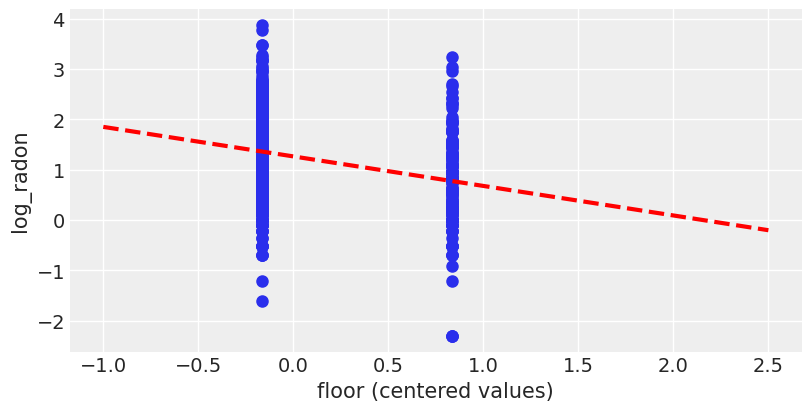

In [10]:
# for simplicity we only show the regression model corresponding 
# to the posterior mean of the parameters

post_pooled = az.extract(pooled_trace)
a_pooled    = post_pooled.alpha.values.mean()
b_pooled    = post_pooled.beta.values.mean()

plt.scatter(floor_c, log_radon)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('floor (centered values)')
plt.ylabel('log_radon');

 # Unpooled model

In [11]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=mu_y, sigma=2 * s_y, shape=n_counties)

    # the slope is the same for all counties
    beta      = pm.Normal('beta', mu=0, sigma=2 * s_y/s_x)
    sigma_y   = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[county] + beta * floor_c
    
    y = pm.Normal('y', mu, sigma=sigma_y, observed=log_radon)
    

In [12]:
with unpooled_model:
    unpooled_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


## Comparing the pooled and unpooled model

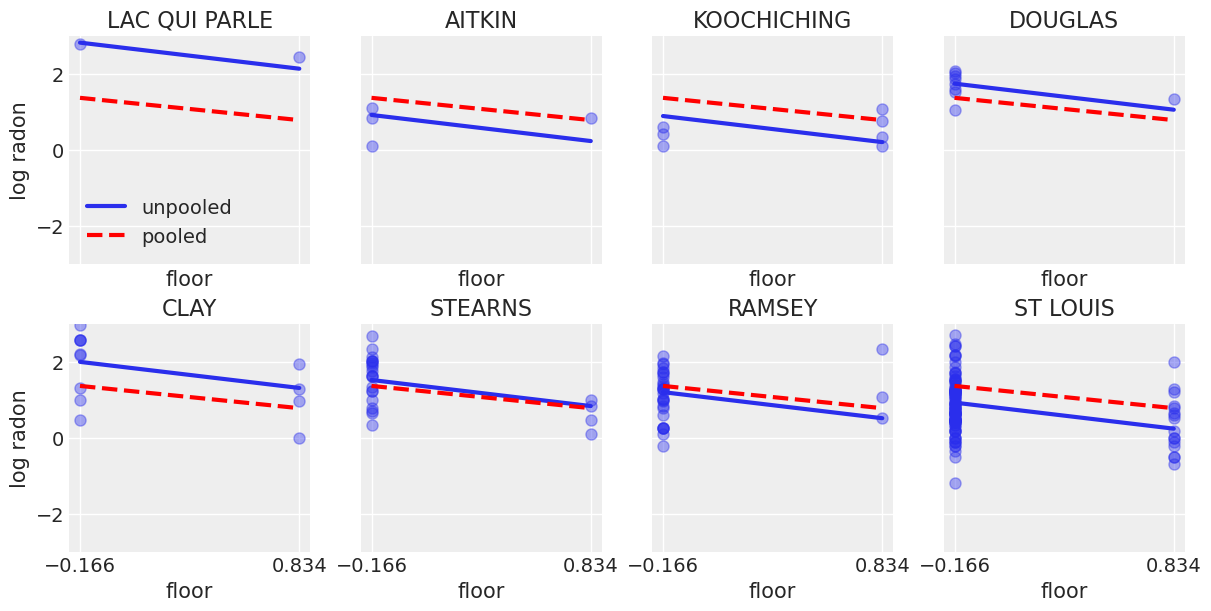

In [18]:
#The code below shows the pooled and unpooled model for some sample counties.
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
unpooled_post = az.extract(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

# intercept of the unpooled model (posterior mean): an array, one element for each county.
alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=counties_list)

for i,c in enumerate(sample_counties):
    #select the subset of observation referring to the specific county
    y = log_radon[radon_data.county==c]
    x = floor_c[radon_data.county==c]
    axes[i].scatter(x, y, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(floor_c.min(), floor_c.max() )
    
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([floor_c.min(), floor_c.max()])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    axes[i].set_xlabel('floor')
    if (i%4 == 0): axes[i].set_ylabel('log radon')
    axes[0].legend()

plt.savefig('img/pooled_unpooled.png')

* The pooled model (red) is fixed and cannot  identify high-radon or low-radon counties

*  On the other hand, the  estimates of the unpooled models (blue)  for countries with few data, such as  LAC QUI PARLE,  are unreliable.

# Hierarchical regression: the *varying intercept* model.


*   A different intercept for each county, assuming the intercepts to be drawn from a population of  intercepts.


* The estimated intercepts are a compromise between the unpooled and the pooled model.

* A shared slope for all counties.

# The  varying-intercept model
* The first three lines are specific to the hierarhical model.
  
* The last three lines are identical to the unpooled model.

\begin{align}
\alpha_j &\sim N(\mu_{\text{pop}}, \sigma_{\text{pop}}) \,\, j=1,2..., 85 && \text{each intercept is a sample from a population}\\
\mu_{\text{pop}} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean of the population of intercepts} \\
\sigma_{\text{pop}} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\\
\beta & \sim N (0,2  \frac{s_y}{s_x} )  && \text{prior on the slope} \\
\sigma & \sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std of the noise}\\
Y &\sim N( \alpha_{county} + \beta X_c,  \sigma) && \text{likelihood} \\
\end{align}

* Broad priors  on the parameters of the population of intercepts

In [29]:
with pm.Model() as hier_model:
    
    # Parameters of the population of intercepts.
    mu_pop    = pm.Normal('mu_pop', mu=mu_y, sigma=10 * s_y)
    sigma_pop = pm.HalfNormal('sigma_pop', 5 * s_y)
    
    # Vector of intercepts; each intercept is drawn from the population
    alpha = pm.Normal('alpha', mu=mu_pop, sigma=sigma_pop, shape=n_counties)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[county] + beta * floor_c, sigma=sigma_y, observed=log_radon)    

In [30]:
with hier_model:
    hier_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_pop, alpha, beta, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


## Partial pooling 

* In general the hierarchical model brings the estimated intercepts closer to the mean of the population (ppooled model) compared to the unpooled model. This way, it reduces their variance.

* The intercept estimated by the varying-intercept model are a compromise (*partial pooling*)  between the pooled and unpooled model.
 
* For counties with few observations, the estimates might be closer to the pooled model (i.e., the state-wide average) than the estimate of the unpooled model.

* For counties with many observations, the estimated intercept is close to that of the  unpooled model.

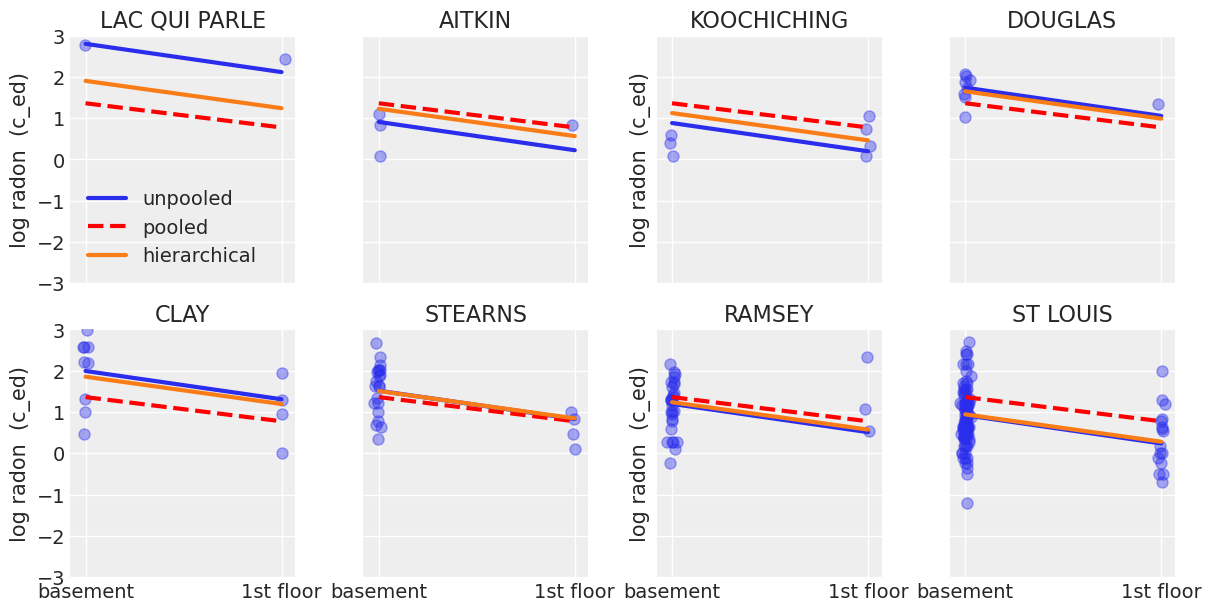

In [31]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier   = az.extract(hier_trace.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each county (samples of each county are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=counties_list)


for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = log_radon[radon_data.county==c]
    x = floor_c[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(floor_c.min(), floor_c.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[county_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[county_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([floor_c.min(), floor_c.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (c_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled_hier.png') 

#  The hierarchical model is a sensible compromise 

* Close to the unpooled model on data-rich counties.

* Close to the pooled model on data-poor counties.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [32]:
# the hierarchical model is on top of the rank
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-1037.176197,49.693533,0.000000,0.921011,27.948978,0.000000,True,log
unpooled,1,-1055.451657,80.230336,18.275460,0.000878,28.340827,5.603942,True,log
pooled,2,-1089.807773,3.663392,52.631577,0.078111,24.993952,10.753835,False,log


# Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group



# Exercise: compute the predictive distributions of different models


*  Compare the predictive distribution  for a  measurement at floor 0 for county "Lac qui parle", using the unpooled and the varying-intercept model.


 * Compute the predictive distribution for a  measurement at floor 0 in a novel county using the  varying-intercept hierarchical model.



* Recall using the centered value of the floor.


    

# Exercise 2: slope-varying, intercept-varying model

* Implement a model which treats  the slope and the intercept in a hierarchical way. 


* Compute the predictive distribution for a measurement at floor 0 for county "Lac qui parle" and for a novel county.


* Compare the model against the previous one using WAIC; which one would you choose?
    
    

# Solutions

In [45]:
#predictive distribution for a new measure in LAC QUI PARLE, using to the unpooled and the varying-intercept model
# In this cell we extract the samples


#get the centered value corresponding to floor0
# np.unique(floor_c) returns an array of two values, corresponding to the centered 
# values of floor 0 and 1.
floor_0 = np.unique(floor_c)[0]


#this value is obtained by 
#np.unique(floor_c)
#array([-0.16648531,  0.83351469])


#get the trace samples
post_hier  = az.extract(hier_trace.posterior)
post_unpooled   = az.extract(unpooled_trace.posterior)

#samples of the slope
beta_hier = post_hier.beta.values
beta_unpooled  = post_unpooled.beta.values

#samples of the intercept for LAC QUI PARLE
alpha_hier = post_hier.alpha.values[county_lookup['LAC QUI PARLE']] 
alpha_unpooled = post_unpooled.alpha.values[county_lookup['LAC QUI PARLE']] 

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values
sigma_y_unpooled =  post_unpooled.sigma_y.values

In [62]:
#Now we compute the predictive distributions
y_new_hier = np.zeros(len(beta_hier))
y_new_unpooled = np.zeros(len(beta_unpooled))

#this could be  vectorized. I leave the for loop over the samples for clarity.
for i, current_mu in enumerate(beta_hier):
        #to have a more precise quantification, we could generate more than one values   with the i-th sample of parameters.
        # that is how pymc3 implements the predictive checks.
        y_new_hier[i] = np.random.normal (loc = alpha_hier[i] + beta_hier[i] *  floor_0 , scale = sigma_y_hier[i])
        y_new_unpooled[i] = np.random.normal (loc = alpha_unpooled[i] + beta_unpooled[i] *  floor_0 , scale = sigma_y_unp[i])

#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
a=  pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unpooled).describe()
c =  pd.concat ([a,b], axis=1)
c.columns = ['hier', 'unpooled']
c #the unpooled model makes a higher prediction with larger uncertainty

,hier,unpooled
count,4000.000000,4000.000000
mean,1.905088,2.788723
std,0.787644,0.871878
min,-0.972316,-1.175638
25%,1.358595,2.211303
50%,1.921048,2.793793
75%,2.432312,3.386026
max,5.056404,5.770032


In [63]:
# predictive distribution for a measure taken in a new county.
# This is only possible with the hierarchical model.
# Part 1 

post_hier    = az.extract(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_pop = post_hier.mu_pop.values
sigma_pop = post_hier.sigma_pop.values
alpha_new = np.zeros(len(mu_pop))

#draw possible intercepts from the population of intercepts
alpha_new = np.random.normal (loc = mu_pop, scale = sigma_pop)

 #samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [64]:
# predictive distribution for a measure taken in a new county.
# Part 2 
        
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,4000.000000
mean,1.503862
std,0.810054
min,-1.391640
25%,0.968120
50%,1.495772
75%,2.039005
max,4.390745


# Varying-slope and varying-intercept model

\begin{align}
\beta_j &\sim N(\mu_{\beta}, \sigma_{\beta}) \,\, j=1,2..., 85&& \text{population of slopes} \\
\mu_{\beta} &\sim N(0,10 s_y)  && \text{prior on the mean slope} \\
\sigma_{\beta} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of slopes}\\
\\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},10 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5 s_y) && \text{prior on the std of intercepts}\\
\\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
Y &\sim N( \alpha_{\text{county}} + \beta_{\text{county}} X_c,  \sigma) && \text{likelihood} \\
\end{align}

In [65]:
with pm.Model() as varying_slope_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a     = pm.Normal('mu_a', mu=mu_y, sigma=10 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 5 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # Population of slopes
    mu_b      = pm.Normal('mu_b', mu=0, sigma=10 * s_y)
    sigma_b = pm.HalfNormal('sigma_b', 5 * s_y)
    beta         = pm.Normal('beta', mu=mu_b, sigma= sigma_b)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[county] + beta * floor_c, sigma=sigma_y, observed=log_radon)    

In [66]:
with varying_slope_model:
    varying_slope_trace = pm.sample(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, mu_b, sigma_b, beta, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 542 divergences after tuning. Increase `target_accept` or reparameterize.


In [67]:
# the varying slope is ranked second
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace, 'varying_slope':varying_slope_trace}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
varying_slope,0,-1036.551961,49.143630,0.000000,0.924659,27.956786,0.000000,True,log
hierarchical,1,-1037.176197,49.693533,0.624236,0.000000,27.948978,0.269992,True,log
unpooled,2,-1055.451657,80.230336,18.899696,0.000000,28.340827,5.616331,True,log
pooled,3,-1089.807773,3.663392,53.255812,0.075341,24.993952,10.737254,False,log


In [68]:
# predictive distribution for lac qui parle
#get the trace samples
post_hier_vt    = az.extract(varying_slope_trace.posterior)

#samples of the intercept for LAC 
alpha_lac_vt = post_hier_vt.alpha.values[county_lookup['LAC QUI PARLE']] 


#samples of the slope for LAC
beta_lac_vt = post_hier_vt.beta.values[county_lookup['LAC QUI PARLE']] 


#samples of sd
sigma_y_vt =  post_hier_vt.sigma_y.values

y_new_vt = np.zeros(len(alpha_lac_vt))
y_new_vt = np.random.normal (loc = alpha_lac_vt + beta_lac_vt *  floor_0 , scale = sigma_y_vt)

pd.DataFrame(y_new_vt).describe()

,0
count,4000.000000
mean,1.905125
std,0.780702
min,-0.811564
25%,1.377796
50%,1.916744
75%,2.439222
max,4.223585
